**Importing some libraries**

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from glob import glob
import librosa
import librosa.display

**Extracting audio paths**

In [ ]:
from google.colab import drive
drive.mount('drive')
audio_files = glob('drive/My Drive/AI certification with Zaka/Capstone Project/Data/*/*.mp3')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


**Creating target feature**

In [ ]:
import re
metadata = pd.DataFrame()
labels = []
for i in audio_files:
  labels.append(re.findall("Portuguese|Arabic|Chinese", i))

metadata['filenames'] = audio_files
metadata['labels'] = np.array(labels).flatten()

**Extracting MFCC features**

In [ ]:
def features_extractor(file):
  audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
  return mfccs_scaled_features

In [ ]:
extracted_features = []
for index_num, row in metadata.iterrows():
  final_class_labels = row['labels']
  data = features_extractor(row['filenames'])
  extracted_features.append([data, final_class_labels])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

**Loading the input and target features into a pandas dataframe**

In [ ]:
extracted_features = pd.DataFrame(extracted_features, columns = ['feature', 'class'])
extracted_features.to_csv('features_extraction.csv')
extracted_features.head()

,feature,class
0,"[-286.9941, 146.95049, 9.473759, 19.820679, -2...",Arabic
1,"[-299.96866, 111.97331, -19.618845, 7.081615, ...",Arabic
2,"[-371.86697, 87.36298, -11.521779, 23.95938, -...",Arabic
3,"[-355.3114, 87.29495, -18.1713, 19.213644, -13...",Arabic
4,"[-321.839, 102.309814, -13.466494, 9.937704, -...",Arabic


In [ ]:
x = np.array(extracted_features['feature'].tolist())
y = np.array(extracted_features['class'].tolist())

In [ ]:
# Label encoding 
y = np.array(pd.get_dummies(y))

In [ ]:
y.shape

(30000, 3)

**Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [ ]:
x_train.shape

(24000, 40)

In [ ]:
x_test.shape

(6000, 40)

**Model Creation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras.optimizers import Adam 
from sklearn import metrics
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [ ]:
labels_number = y.shape[1]

model = Sequential()
## 1st layer 
model.add(Dense(512, input_shape = (40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
## 2nd layer 
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))
## 3rd layer 
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))
## 4th layer 
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
## 5th layer 
model.add(Dense(labels_number))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               20992     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1

In [ ]:
model.compile(loss = 'categorical_crossentropy', metrics=["accuracy", recall, precision], optimizer = 'adam')

**Training the Artificial Neural Network**

In [ ]:
training_model = model.fit(np.array(x_train), y_train, batch_size = 32, epochs = 200, validation_data = (np.array(x_test), y_test))

Epoch 1/200
750/750 [==============================] - 34s 46ms/step - loss: 0.6495 - accuracy: 0.7390 - recall: 0.6424 - precision: 0.8073 - val_loss: 0.5836 - val_accuracy: 0.7580 - val_recall: 0.6512 - val_precision: 0.8359
Epoch 2/200
750/750 [==============================] - 35s 47ms/step - loss: 0.6227 - accuracy: 0.7490 - recall: 0.6567 - precision: 0.8185 - val_loss: 0.6184 - val_accuracy: 0.7337 - val_recall: 0.6390 - val_precision: 0.8029
Epoch 3/200
750/750 [==============================] - 32s 42ms/step - loss: 0.6093 - accuracy: 0.7533 - recall: 0.6610 - precision: 0.8248 - val_loss: 0.5572 - val_accuracy: 0.7708 - val_recall: 0.6780 - val_precision: 0.8424
Epoch 4/200
750/750 [==============================] - 34s 46ms/step - loss: 0.5888 - accuracy: 0.7611 - recall: 0.6770 - precision: 0.8286 - val_loss: 0.5646 - val_accuracy: 0.7593 - val_recall: 0.6472 - val_precision: 0.8528
Epoch 5/200
750/750 [==============================] - 31s 41ms/step - loss: 0.5816 - accura

**Saving the model**

In [ ]:
model.save("model.h5")

In [ ]:
model = load_model('/content/model.h5')

**Model Evaluation**

In [ ]:
model.evaluate(x_test,y_test)

188/188 [==============================] - 2s 8ms/step - loss: 0.4589 - accuracy: 0.8507 - recall: 0.7758 - precision: 0.9042


[0.45891401171684265,
 0.8506666421890259,
 0.7758333086967468,
 0.9042346477508545]

In [ ]:
def model_predict(path, data):
  model_path = path
  model = load_model(model_path)
  predictions = np.argmax(model.predict(x_test),axis = 1)
  return predictions

In [ ]:
predictions = model_predict('/content/model.h5',x_test)

188/188 [==============================] - 2s 9ms/step


In [ ]:
predictions

array([1, 1, 0, ..., 0, 1, 2])

**Metrics for Evaluation**

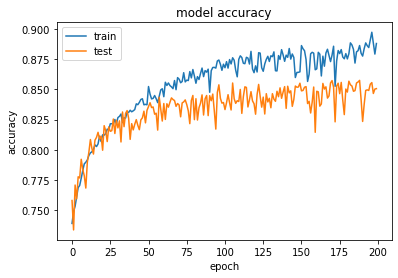

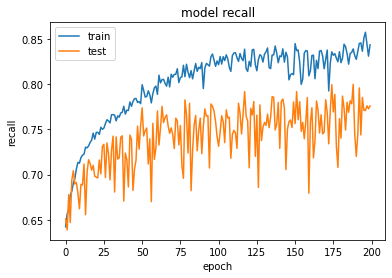

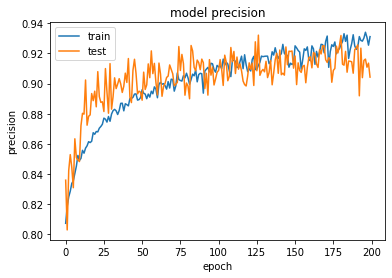

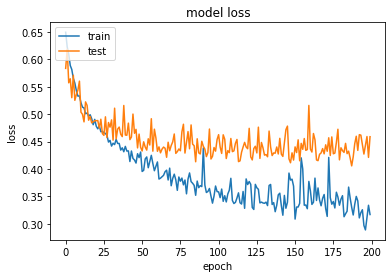

In [ ]:
# Plot the model's training and validation accuracy
plt.plot(training_model.history['accuracy'])
plt.plot(training_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation recall
plt.plot(training_model.history['recall'])
plt.plot(training_model.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation precision
plt.plot(training_model.history['precision'])
plt.plot(training_model.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation loss
plt.plot(training_model.history['loss'])
plt.plot(training_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Comparing actual and predicted results**

In [ ]:
df_actual = pd.DataFrame(y_test, columns = ['Arabic', 'Portuguese', 'Chinese'])
df_pred = pd.DataFrame(y_pred.round(), columns = ['Arabic', 'Portuguese', 'Chinese'])
df = pd.concat([df_actual, df_pred], axis = 1)
df

,Arabic,Portuguese,Chinese,Arabic,Portuguese,Chinese
0,1,0,0,1.0,0.0,0.0
1,0,1,0,0.0,1.0,0.0
2,0,1,0,0.0,1.0,0.0
3,0,0,1,0.0,1.0,0.0
4,0,1,0,0.0,0.0,1.0
...,...,...,...,...,...,...
5995,0,0,1,0.0,0.0,0.0
5996,0,1,0,0.0,1.0,0.0
5997,1,0,0,1.0,0.0,0.0
5998,1,0,0,1.0,0.0,0.0
